# 프로젝트 수행

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해 주세요.
  (어떠한 방법을 사용했는지 적어주세요.)
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해 주세요.
3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용해 주세요.
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.
5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

# 라이브러리

In [2]:
import os
import math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from glob import glob

import tensorflow as tf

from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

# 데이터 확인, 이미지 분할

In [3]:
data_path = './cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [4]:
# 이미지 하나를 열어 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [5]:
#(256, 256, 3) 크기의 2개 이미지로 분할

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

In [13]:
def show_img(img1, img2):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img1)
    plt.subplot(1,2,2); plt.imshow(img2)
    plt.tight_layout()

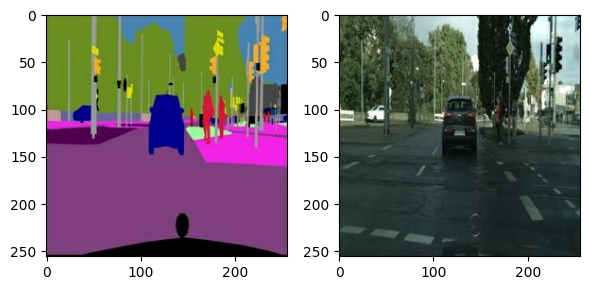

In [61]:
f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

show_img(denormalize(input_image), denormalize(real_image))

# Augmentation

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

In [ ]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

# Augmentation - 다른 라이브러리 샘플

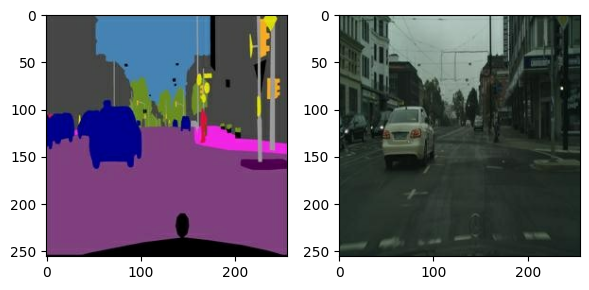

In [66]:
import cv2

img_path = os.listdir(data_path)
rnd_idx = np.random.randint(0, len(img_path)+1, size=5)  # 랜덤 선택

tmp_path = data_path + img_path[rnd_idx[0]]
tmp_img = cv2.imread(tmp_path)

tmp_input, tmp_real = load_img(tmp_path)
show_img(denormalize(tmp_input), denormalize(tmp_real))

## imgaug

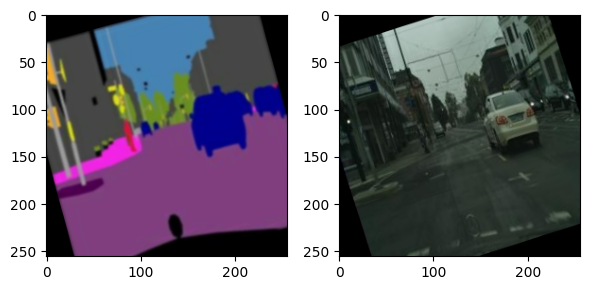

In [69]:
import imgaug.augmenters as iaa

# Define the augmentation sequence
aug_iaa = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with a 50% chance
    iaa.GaussianBlur(sigma=(0, 3.0)),  # Apply random Gaussian blur
    iaa.Affine(rotate=(-45, 45))  # Rotate the image by -45 to +45 degrees
])

# Read and augment an image
iaa_input = aug_iaa(image=denormalize(tmp_input))
iaa_real = aug_iaa(image=denormalize(tmp_real))

show_img(iaa_input, iaa_real)

## albumentations

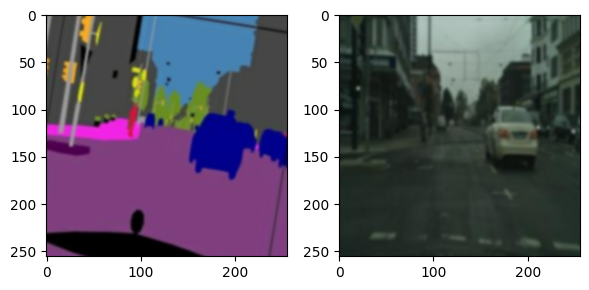

In [70]:
import albumentations as A
import cv2

# Define the augmentation pipeline
alb_augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),  # Horizontal flip with a 50% chance
    A.GaussianBlur(blur_limit=(3, 7)),  # Apply random Gaussian blur
    A.Rotate(limit=(-45, 45), p=0.8)  # Rotate the image by -45 to +45 degrees with 80% probability
])

# Read and augment an image
alb_input = alb_augmentation(image=denormalize(tmp_input))["image"]
alb_real = alb_augmentation(image=denormalize(tmp_real))["image"]

show_img(alb_input, alb_real)

## Augmentor

In [32]:
import Augmentor
from PIL import Image

# Define the augmentation pipeline
p = Augmentor.Pipeline(data_path)
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)  # Random rotation between -10 to +10 degrees
p.flip_left_right(probability=0.5)  # Horizontal flip with a 50% chance
p.random_brightness(probability=0.3, min_factor=0.8, max_factor=1.2)  # Random brightness adjustment

Initialised with 1000 image(s) found.
Output directory set to ./cityscapes/train/output.

In [33]:
# Generate augmented images
p.sample(100)  # Generate 5 augmented images

Processing <PIL.Image.Image image mode=RGB size=512x256 at 0x294A28C10>: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 467.73 Samples/s]


> 이 라이브러리는 샘플 파일을 생성함

In [ ]:
output_path = data_path + 'output/'
output_files = os.listdir(output_path)

[ 25 121 129 120  84]
./cityscapes/train/output/train_original_703.jpg_717cdce3-d262-48ef-89b9-7fe99a73b320.jpg


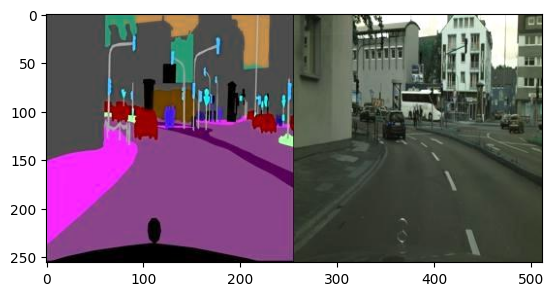

In [59]:
# 이미지 하나를 열어 크기 확인
rand_pick = np.random.randint(0, len(output_files)+1, size=5)
print(rand_pick)
f_aug = output_path + os.listdir(output_path)[rand_pick[0]]
print(f_aug)
aug_img = cv2.imread(f_aug, cv2.IMREAD_COLOR)
plt.imshow(aug_img)

# 학습 데이터 이미지

In [ ]:
# 이미지 불러와서 증강 작업 
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

In [10]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

In [11]:
# 랜덤 5개 추출
train_len = len(train_images)
random_5 = np.random.randint(0, train_len+1, size=5)

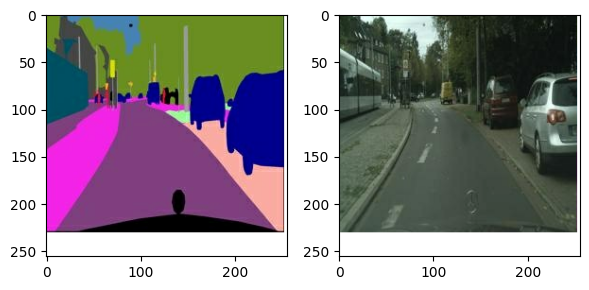

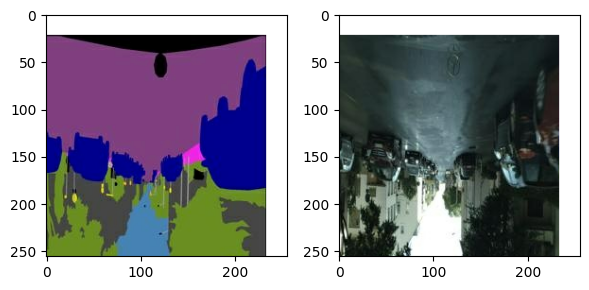

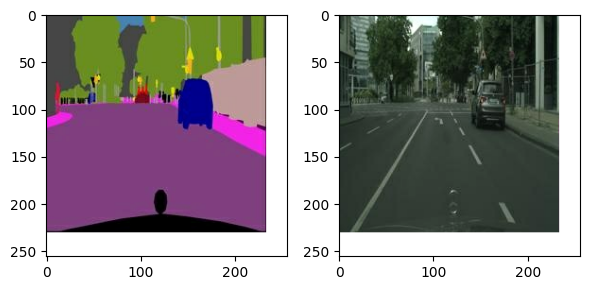

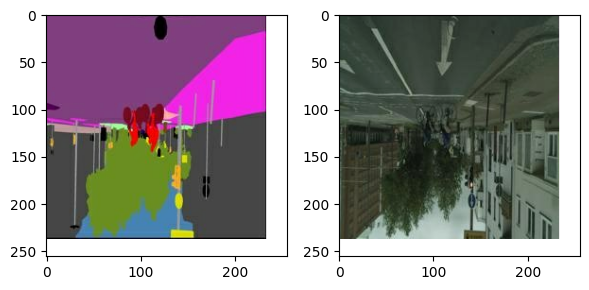

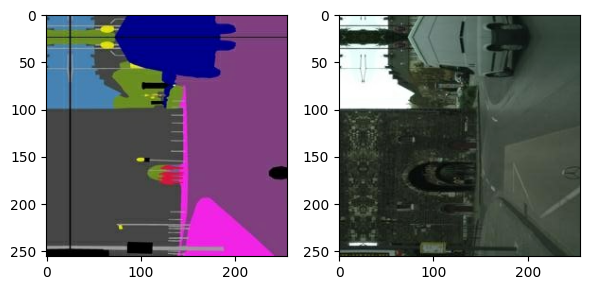

In [14]:
# 랜덤으로 추출된 5개 이미지 시각화
for i in random_5:
    sample = train_images.take(i)
    sample = list(sample.as_numpy_iterator())
    sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
    plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))
    
    plt.tight_layout()

# U-Net Generator

In [41]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [42]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [43]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [44]:
UNetGenerator().get_summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

# Discriminator

In [45]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [46]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
            
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [47]:
Discriminator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_56 (Concatenate)    (None, 256, 256, 6)  0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
disc_block_35 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_56[0][0]       

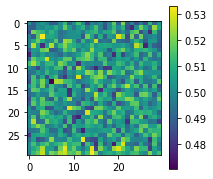

In [48]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)

plt.figure(figsize=(3,3))
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습

In [49]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [50]:
gene_opt = Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = Adam(2e-4, beta_1=.5, beta_2=.999)

In [60]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [61]:
# 에포크
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
steps = len(train_images)

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        # 10% 진행될 때마다 출력
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % steps == 0:
            print('\n\n')
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[1] - STEP[250]                     
Generator_loss:2.5257                     
L1_loss:0.1931                     
Discriminator_loss:0.5634

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[2] - STEP[250]                     
Generator_loss:1.9024                     
L1_loss:0.1705                     
Discriminator_loss:0.6731

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[3] - STEP[250]                     
Generator_loss:2.2707                     
L1_loss:0.1511                     
Discriminator_loss:0.6859

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[4] - STEP[250]                     
Generator_loss:0.9944                     
L1_loss:0.2007                     
Discriminator_loss:1.0316

  0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 


EPOCH[5] - STEP[250]                     
Generator_loss:1.9613                     
L1_loss:0.1709                     
Discriminator_loss:0.5

# loss 시각화

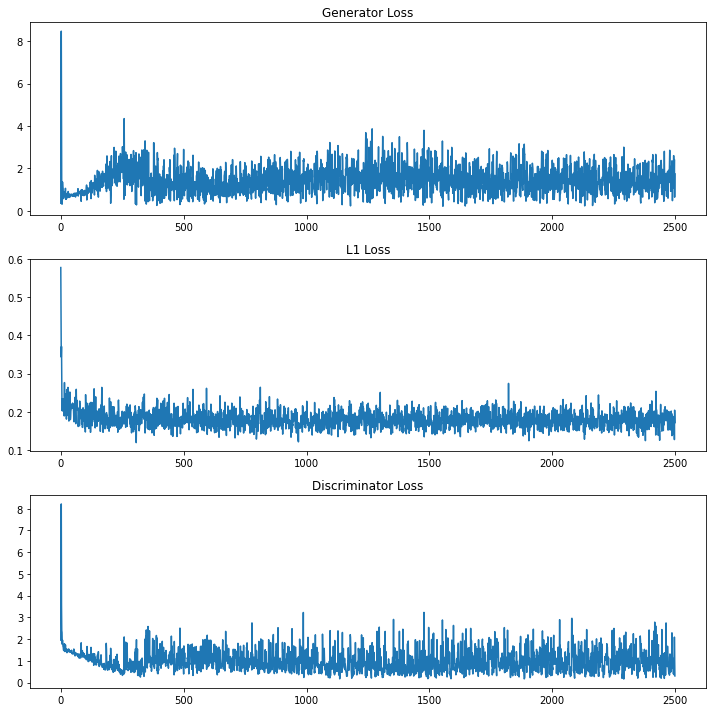

In [62]:
plt.figure(figsize=(10,10))

# generator
plt.subplot(311)
plt.plot(history['gen_loss'])
plt.title('Generator Loss')

# l1
plt.subplot(312)
plt.plot(history['l1_loss'])
plt.title('L1 Loss')

# discriminator
plt.subplot(313)
plt.plot(history['disc_loss'])
plt.title('Discriminator Loss')

plt.tight_layout()
plt.show()

# Test

In [63]:
test_path = './cityscapes/val/'
print("number of train examples :", len(os.listdir(test_path)))

number of train examples : 5


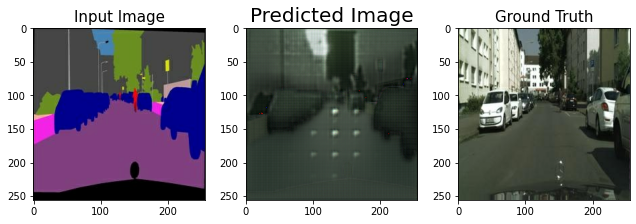

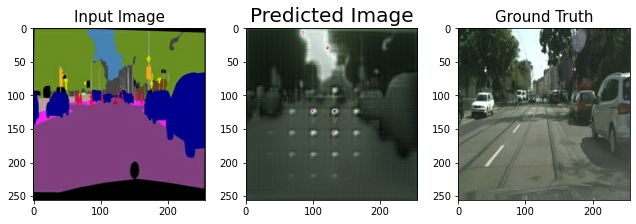

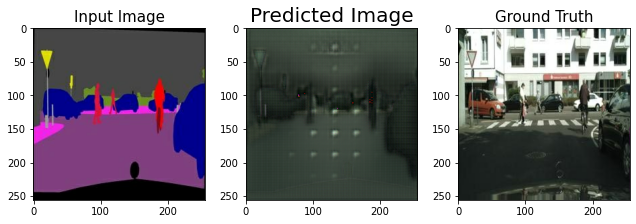

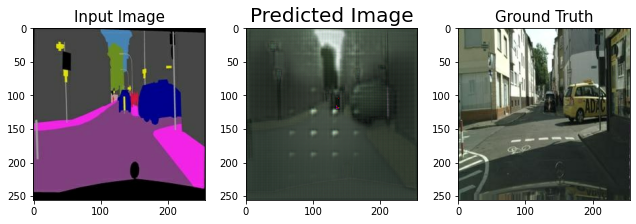

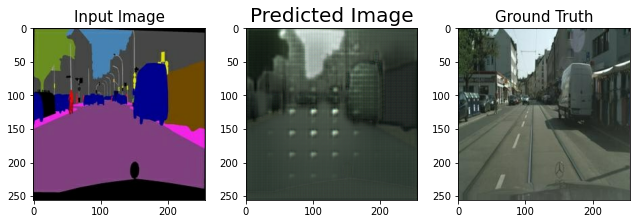

In [64]:
#도로 이미지 만들기
for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=20)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)
    plt.tight_layout()